## Imports

In [1]:
# Load GPT-2 model and tokenizer
from transformers import GPT2Model, GPT2Tokenizer
from baukit import TraceDict
import torch
import matplotlib.pyplot as plt
import numpy as np


/home/oso/anaconda3/envs/keras-jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading GPT and Text samples

In [8]:
# Load GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2Model.from_pretrained(model_name).to("cuda:1")
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/home/oso/anaconda3/envs/keras-jax/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
print(model)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [10]:
texts = [
    "Hello, I'm Luis from Spain.",
    "The quick brown fox jumps over the lazy dog.",
    "Machine learning is transforming the world.",
    "GPT-2 is a powerful language model.",
    "Climate change is one of the biggest challenges of our time.",
    "Artificial intelligence is revolutionizing healthcare.",
    "The stock market fluctuates based on economic news.",
    "Space exploration has always fascinated humanity.",
    "Cooking delicious meals is an art and science.",
    "The history of ancient civilizations is intriguing.",
    "Reading books expands your knowledge and imagination.",
    "Programming requires logical thinking and creativity.",
    "The cat sat on the mat.",
    "Robots are increasingly being used in manufacturing.",
    "Exercise is essential for maintaining good health.",
    "Traveling opens your mind to new cultures and ideas.",
    "The Internet has transformed how we communicate.",
    "Music has the power to evoke deep emotions.",
    "Education is the key to unlocking opportunities.",
    "Cryptocurrencies are disrupting traditional finance.",
    "Elections determine the future of governments.",
    "Renewable energy sources are critical for sustainability.",
    "Philosophy questions the nature of reality and existence.",
    "Wildlife conservation is vital for biodiversity.",
    "The universe is vast and full of mysteries.",
    "Hiking in nature is a rejuvenating experience.",
    "Learning new languages improves cognitive skills.",
    "The Renaissance was a period of immense cultural growth.",
    "Artificial intelligence can outperform humans in some tasks.",
    "Water is essential for all forms of life.",
    "The Great Wall of China is an architectural marvel.",
    "Blockchain technology enables secure transactions.",
    "The study of astronomy reveals the secrets of the cosmos.",
    "Teamwork is crucial for achieving success in any field.",
    "Data science involves analyzing large datasets for insights.",
    "The pyramids of Egypt are wonders of the ancient world.",
    "Self-driving cars are the future of transportation.",
    "Meditation helps reduce stress and improve focus.",
    "The brain is the most complex organ in the human body.",
    "The art of painting captures the beauty of the world.",
    "Video games have become a popular form of entertainment.",
    "Global trade connects economies around the world.",
    "Sports bring people together and promote physical activity.",
    "Digital marketing is essential for modern businesses.",
    "The oceans cover more than 70% of Earth's surface.",
    "SpaceX is advancing space travel with reusable rockets.",
    "Learning history helps us understand the present.",
    "Artificial neural networks are inspired by the human brain.",
    "The Eiffel Tower is an iconic landmark in Paris.",
    "Virtual reality offers immersive experiences in gaming.",
    "Healthy eating is important for a balanced lifestyle.",
    "The discovery of antibiotics revolutionized medicine.",
    "Mountains provide breathtaking views and adventure."
]


## Tokenize inputs

In [4]:

max_length = 20 
inputs = tokenizer(
    texts,
    return_tensors="pt",
    padding="max_length",  # Pad to the max_length
    truncation=True,       # Truncate if input exceeds max_length
    max_length=max_length  # Specify the length to pad/truncate to
)

inputs = {key: val.to("cuda:1") for key, val in inputs.items()}



## Hooking model with Baukit and plot

Here we will hook a layer, in this case the ln_2 at the layer number 6 and we will gather the activations.
When done that, we substract the mean activation of each token and compute the L2 norm. Later, we can plot the historgram:

In [5]:
# Selecting the layer to hook

hook_layers = ["h.6.ln_2"] # we can add more here

# Using baukit to hook the layer
with TraceDict(model, layers=hook_layers, retain_input=True, retain_output=True) as rep:
    outputs = model(**inputs, output_hidden_states=True)

    # Access the output from the hooked layer
    activations = rep['h.6.ln_2'].output  # Shape: [batch_size, seq_length, hidden_dim]
    
    # Subtract mean activation for each token
    mean_subtracted = activations - activations.mean(dim=-1, keepdim=True)
    
    # Compute the L2 norm for each token's activation vector
    norms = torch.norm(mean_subtracted, dim=-1)  # Shape: [batch_size, seq_length]
    
    # Flatten norms across all batches and sequences
    flattened_norms = norms.view(-1).tolist()



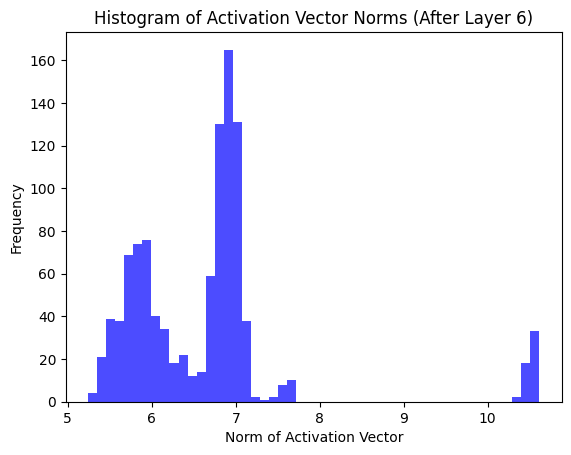

Mean Norm: 6.658634734603594
Variance of Norms: 1.0896326661873386
Standard Deviation of Norms: 1.043854715076451


In [6]:

# Plot histogram of norms
plt.hist(flattened_norms, bins=50, alpha=0.7, color='blue')
plt.xlabel('Norm of Activation Vector')
plt.ylabel('Frequency')
plt.title('Histogram of Activation Vector Norms (After Layer 6)')
plt.show()

print("Mean Norm:", np.mean(flattened_norms))
print("Variance of Norms:", np.var(flattened_norms))
print("Standard Deviation of Norms:", np.std(flattened_norms))